In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import sys, os
scr_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(scr_dir)


from load import TimeSeriesLoader
import warnings
warnings.filterwarnings('ignore')
# import preprocessing
from preprocess import (
    create_rolling_ts, 
    split_data, 
    flatten,
    series_to_supervised,
    train_test_split
)

from error_metrics import regression_metrics


## Import data from archive

In [2]:
ROOT_PATH = 'C://Users/gilbe/Documents/aifi-bootcamp'
df = pd.read_csv(f'{ROOT_PATH}/data/aapl.csv')
df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index('Unnamed: 0', inplace=True)
df.index.rename('Date', inplace=True)
# df.rename(columns={'Unnamed: 0', 'Date'}, inplace=True)
df.head()

,1. open,2. high,3. low,4. close,5. volume
Date,,,,,
2022-01-24 04:05:00,162.0632,162.9520,162.0632,162.6025,10936.0
2022-01-24 04:10:00,162.7423,162.9620,162.6225,162.9620,7705.0
2022-01-24 04:15:00,162.7922,162.7922,162.5925,162.7623,7305.0
2022-01-24 04:20:00,162.6924,162.7223,162.3928,162.4627,9290.0
2022-01-24 04:25:00,162.3129,162.4826,162.2729,162.4327,6117.0


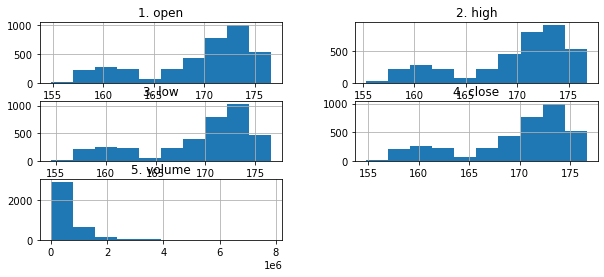

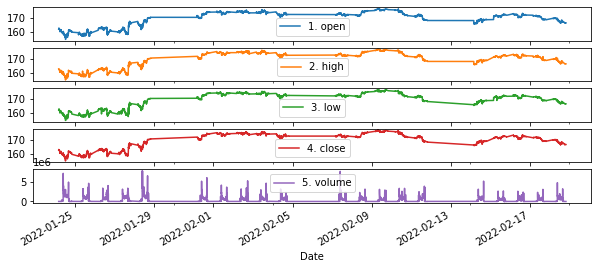

In [3]:
df.hist(figsize=(10, 4));
df.plot(figsize=(10, 4), subplots=True);

In [4]:
df[20:31]

,1. open,2. high,3. low,4. close,5. volume
Date,,,,,
2022-01-24 05:45:00,160.9446,160.9446,159.9159,160.1956,21542.0
2022-01-24 05:50:00,160.1956,160.6550,160.1656,160.6550,23199.0
2022-01-24 05:55:00,160.5751,160.6949,160.4353,160.6650,15911.0
2022-01-24 06:00:00,160.7349,161.1943,160.7349,161.1943,25792.0
2022-01-24 06:05:00,161.1543,161.2642,161.0045,161.0744,21089.0
2022-01-24 06:10:00,161.0744,161.7136,161.0744,161.4739,20718.0
2022-01-24 06:15:00,161.3940,161.5339,161.3940,161.5339,5443.0
2022-01-24 06:20:00,161.5538,162.0432,161.1344,161.1344,16807.0
2022-01-24 06:25:00,161.1444,161.2542,161.1244,161.1244,5881.0


In [5]:
data = series_to_supervised(df[['4. close']], n_in=5)
data[:5]

array([[162.6025, 162.962 , 162.7623, 162.4627, 162.4327, 162.4926],
       [162.962 , 162.7623, 162.4627, 162.4327, 162.4926, 162.5526],
       [162.7623, 162.4627, 162.4327, 162.4926, 162.5526, 162.7124],
       [162.4627, 162.4327, 162.4926, 162.5526, 162.7124, 162.7323],
       [162.4327, 162.4926, 162.5526, 162.7124, 162.7323, 162.5725]])

# Create train-val-test

In [6]:
data_train, data_val, data_test = split_data(df[['4. close']], train_size=.75, valid_size=.125)
print(data_train)

xtrain, ytrain = create_rolling_ts(input_data=data_train.pct_change(), lookback=30, return_np_array=True)
xval, yval = create_rolling_ts(input_data=data_val.pct_change(), lookback=30, return_np_array=True)
xtest, ytest = create_rolling_ts(input_data=data_test.pct_change(), lookback=30, return_np_array=True)


# Flatten data to N X 1 dimensions
xtrain, ytrain = flatten(xtrain), flatten(ytrain)
xval, yval = flatten(xval), flatten(yval)
xtest, ytest = flatten(xtest), flatten(ytest)

                     4. close
Date                         
2022-01-24 04:05:00  162.6025
2022-01-24 04:10:00  162.9620
2022-01-24 04:15:00  162.7623
2022-01-24 04:20:00  162.4627
2022-01-24 04:25:00  162.4327
...                       ...
2022-02-11 18:15:00  168.6000
2022-02-11 18:20:00  168.5200
2022-02-11 18:25:00  168.5600
2022-02-11 18:30:00  168.5099
2022-02-11 18:35:00  168.5000

[2823 rows x 1 columns]


In [7]:
xtrain[20:30, :10], ytrain[:10], xtrain.shape

(array([[-5.51760444e-03,  2.40000000e+01,  1.00000000e+00,
          2.40000000e+01,  5.00000000e+00,  2.86774418e-03,
          2.40000000e+01,  1.00000000e+00,  2.40000000e+01,
          5.00000000e+00],
        [ 2.86774418e-03,  2.40000000e+01,  1.00000000e+00,
          2.40000000e+01,  5.00000000e+00,  6.22451838e-05,
          2.40000000e+01,  1.00000000e+00,  2.40000000e+01,
          5.00000000e+00],
        [ 6.22451838e-05,  2.40000000e+01,  1.00000000e+00,
          2.40000000e+01,  5.00000000e+00,  3.29443251e-03,
          2.40000000e+01,  1.00000000e+00,  2.40000000e+01,
          6.00000000e+00],
        [ 3.29443251e-03,  2.40000000e+01,  1.00000000e+00,
          2.40000000e+01,  6.00000000e+00, -7.43822827e-04,
          2.40000000e+01,  1.00000000e+00,  2.40000000e+01,
          6.00000000e+00],
        [-7.43822827e-04,  2.40000000e+01,  1.00000000e+00,
          2.40000000e+01,  6.00000000e+00,  2.48022032e-03,
          2.40000000e+01,  1.00000000e+00,  2.400000

In [8]:
xtrain.shape, ytrain.shape

((2793, 150), (2793, 1))

In [9]:
xtrain.reshape(xtrain.shape[0], -1).shape, ytrain.reshape(ytrain.shape[0], -1).shape

((2793, 150), (2793, 1))

In [10]:
# xt, yt = train_test_split(data_train, 30)

In [11]:
regressor = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=800, 
    max_depth=5
)


regressor.fit(xtrain.reshape(xtrain.shape[0], -1), ytrain.reshape(ytrain.shape[0], -1))



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=800, n_jobs=8,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

mse-train: 4.7474463715483165e-07 mse-val: 2.39748568722698e-06
r2-train: 0.8607949847152736 r2-val: -0.17616748080365552
smape-train: 42.11531462209102 smape-val: -37.17237719652656


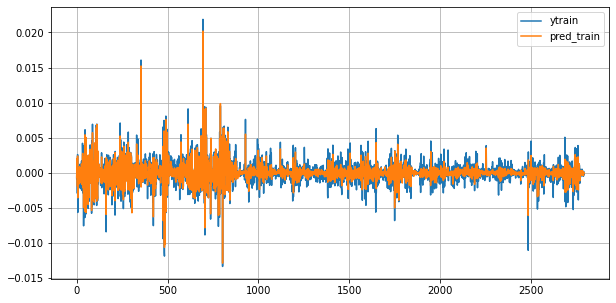

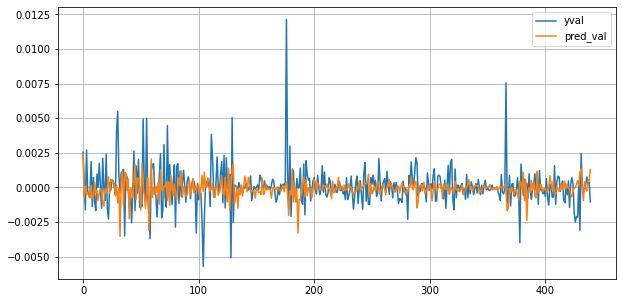

In [12]:
pred_train = regressor.predict(xtrain)
pred_val = regressor.predict(xval)
mse_train, r2_train, mae_train, smape_train = regression_metrics(ytrain, pred_train)
mse_val, r2_val, mae_val, smape_val = regression_metrics(yval, pred_val)
print('mse-train:', mse_train, 'mse-val:', mse_val)
print('r2-train:', r2_train, 'r2-val:', r2_val)
print('smape-train:', smape_train, 'smape-val:', smape_val)


df_train = pd.DataFrame(
    {
        'ytrain': ytrain.reshape(-1), 
        'pred_train': pred_train.reshape(-1), 
    }
).plot(figsize=(10, 5), grid=True);

df_train = pd.DataFrame(
    {
         'yval': yval.reshape(-1), 
         'pred_val': pred_val.reshape(-1)
        }
).plot(figsize=(10, 5), grid=True);